In [69]:
!pip3 install catboost xgboost

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# modelling
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
# from  xgboost import XGBRegressor

In [71]:
df = pd.read_csv('./data/StudentsPerformance.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [72]:
# making all the features as independent and only math score as dependent(output feature)
X = df.drop(columns=['math score'], axis = 1)
# df.head()
X

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75
...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,99,95
996,male,group C,high school,free/reduced,none,55,55
997,female,group C,high school,free/reduced,completed,71,65
998,female,group D,some college,standard,completed,78,77


In [73]:
# x columns before column Transformer
X.shape

(1000, 7)

In [74]:
# output features
y = df['math score']
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math score, Length: 1000, dtype: int64

For categorical data ----> we first perform one hot encoding
once the categories ---> get converted to numerical features  ---> we can apply standardization/normalization.

We create hence create a pipeline to follow this as a step by step process

In [75]:
# create column transformer with 3 types of transformers
numeric_features = X.select_dtypes(exclude='object').columns
categorical_features = X.select_dtypes(include='object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# standardize the numerical features
numeric_transformer = StandardScaler()

# one hot encoding for categorical data ---> to have numerical representation for each category
categorical_transformer = OneHotEncoder()

# ColumnTransformer combines the 2 process step by step 
#  first ---> one hot encoding should happen, then --> standarddization
# creating the pipeline using Columntransformer to transform the column values of the dataset
preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", categorical_transformer, categorical_features),
        ("StandardScaler", numeric_transformer, numeric_features)
    ]
)

In [76]:
# fit the training data using the preprocessor ColumnTransformer
X = preprocessor.fit_transform(X)
X.shape

(1000, 19)

train test split 

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((750, 19), (250, 19))

Create an Evaluation function to give all metrics after model selection

In [80]:
def evaluate_model(true_data, predicted_data):
    mae = mean_absolute_error(true_data,predicted_data)
    mse = mean_squared_error(true_data, predicted_data)
    rmse = np.sqrt(mean_squared_error(true_data, predicted_data))
    r2_square = r2_score(true_data, predicted_data)
    return mae, mse, rmse, r2_square

In [82]:
models = {
    "Linear Regression" : LinearRegression(),
    "Lasso" : Lasso(),
    "Ridge":Ridge(),
    "K-Neighbours Regressor": KNeighborsRegressor(),
    "Decission Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor":AdaBoostRegressor()
}
model_list = []
r2_list = []
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)

    # make predictions 
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # evaluate train and test dataset (evaluate_model returns MAE, MSE, RMSE, R2)
    model_train_mae, model_train_mse, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_mse, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    # Add the missing print statements and fix the append call
    print(list(models.keys())[i])
    model_name = list(models.keys())[i] # Store the current model name
    model_list.append(model_name)

    # Print results for the current model
    print('Model Training Performance')
    print(f'- MAE: {model_train_mae:.4f}')
    print(f'- MSE: {model_train_mse:.4f}')
    print(f'- RMSE: {model_train_rmse:.4f}')
    print(f'- R2 Score: {model_train_r2:.4f}')
    
    print('Model Test Performance')
    print(f'- MAE: {model_test_mae:.4f}')
    print(f'- MSE: {model_test_mse:.4f}')
    print(f'- RMSE: {model_test_rmse:.4f}')
    print(f'- R2 Score: {model_test_r2:.4f}')

    r2_list.append(model_test_r2) # Append the R2 score to the list for later use

    print('='*35) # Separator for clarity
    print('\n') # Newline for readability


Linear Regression
Model Training Performance
- MAE: 4.2383
- MSE: 28.0608
- RMSE: 5.2972
- R2 Score: 0.8743
Model Test Performance
- MAE: 4.3379
- MSE: 30.0581
- RMSE: 5.4825
- R2 Score: 0.8778


Lasso
Model Training Performance
- MAE: 5.1837
- MSE: 42.9223
- RMSE: 6.5515
- R2 Score: 0.8077
Model Test Performance
- MAE: 5.2217
- MSE: 44.2775
- RMSE: 6.6541
- R2 Score: 0.8200


Ridge
Model Training Performance
- MAE: 4.2368
- MSE: 28.0642
- RMSE: 5.2976
- R2 Score: 0.8743
Model Test Performance
- MAE: 4.3354
- MSE: 30.0173
- RMSE: 5.4788
- R2 Score: 0.8780


K-Neighbours Regressor
Model Training Performance
- MAE: 4.5861
- MSE: 33.5462
- RMSE: 5.7919
- R2 Score: 0.8497
Model Test Performance
- MAE: 5.5208
- MSE: 50.8760
- RMSE: 7.1327
- R2 Score: 0.7932


Decission Tree
Model Training Performance
- MAE: 0.0200
- MSE: 0.0833
- RMSE: 0.2887
- R2 Score: 0.9996
Model Test Performance
- MAE: 5.9720
- MSE: 57.9400
- RMSE: 7.6118
- R2 Score: 0.7645


Random Forest Regressor
Model Training Perf

Results

In [83]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2 Score']).sort_values(by=['R2 Score'], ascending=False)

,Model Name,R2 Score
2,Ridge,0.877990
0,Linear Regression,0.877824
6,CatBoosting Regressor,0.854830
7,AdaBoost Regressor,0.851040
5,Random Forest Regressor,0.848962
1,Lasso,0.820027
3,K-Neighbours Regressor,0.793207
4,Decission Tree,0.764494


After comparison of r2 score of each model we can go with Linear Regression as all are approximately 0.8

Linear Regression

In [84]:
linear_model = LinearRegression(fit_intercept=True)
linear_model = linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print("Accuracy of the model is %.2f" %score)


Accuracy of the model is 87.78


Graph plot btw y_pred and y_test

Text(0, 0.5, 'Predicted')

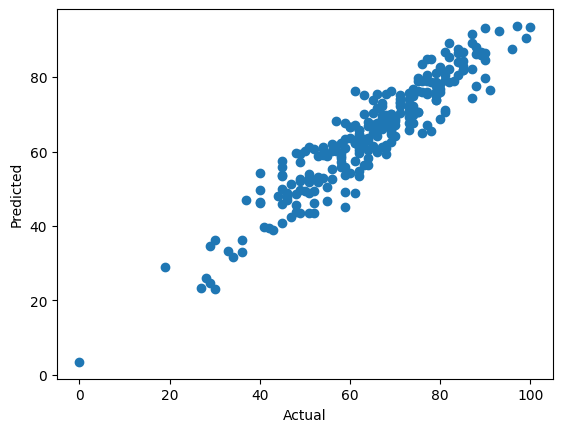

In [85]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='math score'>

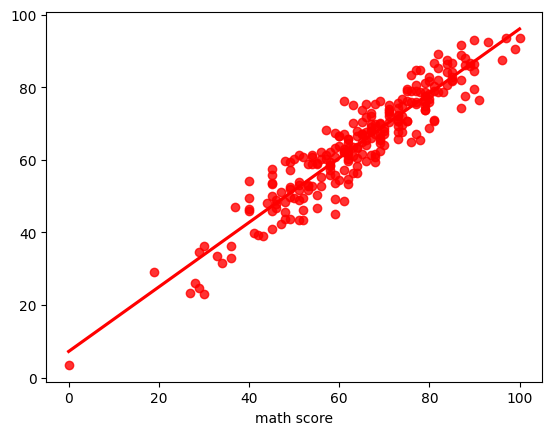

In [86]:
sns.regplot(x=y_test, y=y_pred, ci=None, color='red')

Difference between actual & predicted values

In [89]:
predicted_diff = pd.DataFrame({
    'Actual Value': y_test,
    'Predicted Value': y_test_pred,
    'Difference': y_test - y_test_pred  # Corrected variable name to y_test_pred
})
predicted_diff

,Actual Value,Predicted Value,Difference
521,91,77.747863,13.252137
737,53,56.131387,-3.131387
740,80,77.400000,2.600000
660,74,77.297710,-3.297710
411,84,82.620690,1.379310
...,...,...,...
109,70,61.491150,8.508850
430,64,64.985294,-0.985294
77,80,78.822785,1.177215
84,42,40.683761,1.316239
